(375, 500, 3)


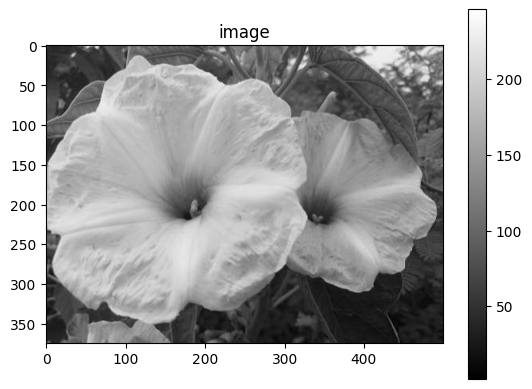

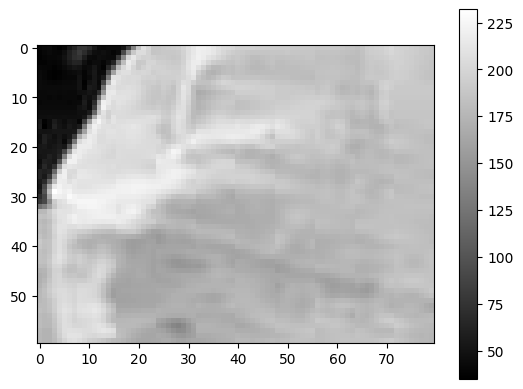

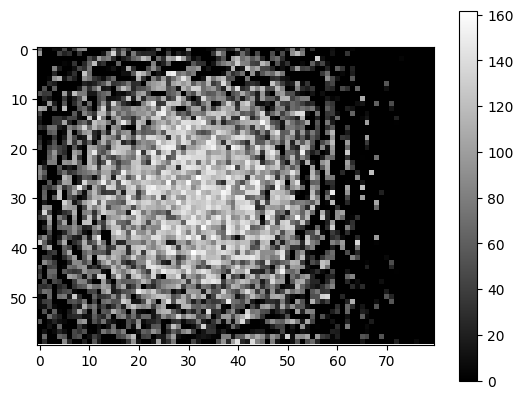

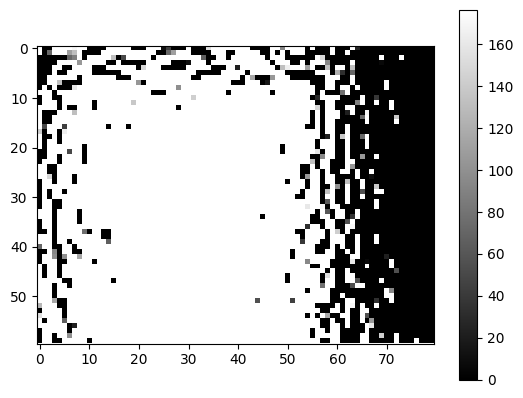

In [1]:

#the second optimal method
import cv2 as op
import numpy as np
from scipy import ndimage
from scipy.sparse import spdiags
from scipy.sparse.linalg import bicgstab
import matplotlib.pyplot as plt


def discrete_laplacian_2d_matrix(m, n):
    """
    生成一个m x n的二维离散拉普拉斯算子的系统矩阵。
    
    参数:
    m, n -- 矩阵的行和列的大小
    
    返回:
    L -- 二维离散拉普拉斯算子的系统矩阵
    """
    # 初始化矩阵
    L = np.zeros((m * n, m * n))
    
    # 遍历每个像素点
    for i in range(m):
        for j in range(n):
            idx = i * n + j  # 当前像素的索引
            # 计算拉普拉斯算子
            if i > 0:  # 上
                L[idx, idx - n] = 1
            if i < m - 1:  # 下
                L[idx, idx + n] = 1
            if j > 0:  # 左
                L[idx, idx - 1] = 1
            if j < n - 1:  # 右
                L[idx, idx + 1] = 1
            # 主对角线元素
            L[idx, idx] = -4
    
    return L


im=op.imread("imageonline.jpg")
#用于处理的灰度目标图像
print(im.shape)

plt.imshow(im, cmap='gray')
plt.colorbar()
plt.title('image')
plt.show()

gray=im[120:180,0:80,0]
gray_x=gray.shape[0]
gray_y=gray.shape[1]

#准备x_map和y_map以及准直光束矩阵
x_map=np.tile(np.arange(gray_x).reshape(gray_x,1),(1,gray_y))
y_map=np.tile(np.arange(gray_y),(gray_x,1))

gray_energy=np.sum(gray)/(gray_x*gray_y)
incident=np.ones((gray_x,gray_y))*gray_energy

#设置焦距
#f=10

#全一矩阵
one=np.ones((gray_x,gray_y))

#laplacian矩阵
L_2D=discrete_laplacian_2d_matrix(gray_x,gray_y)

plt.imshow(gray, cmap='gray')
plt.colorbar()
plt.show()

    
#迭代算法
for count in range(1,11):
    gray_delete=gray-one

    #把原来图像化成列向量
    gray_column=gray_delete.reshape(-1,1)

    #print(gray.shape)

    #使用双共轭梯度稳定迭代法求解 Ax = b
    p,exitcode=bicgstab(L_2D,gray_column,atol=1)

    p=p.reshape(gray_x,gray_y)
    p=p%(2*np.pi)
    #print(p)

    #输出检测
    #plt.imshow(p, cmap='gray')
    #plt.colorbar()
    #plt.title('phase function')
    #plt.show()
    #print(p,exitcode)

    #\partial p
    # 计算矩阵 p 的 Sobel 梯度
    dp_dx = ndimage.sobel(p, axis=0)  # x 方向上的梯度
    dp_dy = ndimage.sobel(p, axis=1)  # y 方向上的梯度

    #print(dp_dx)
    #print(dp_dy)

    # 映射后的坐标
    x_new = (x_map + dp_dx).astype(np.float32)
    y_new = (y_map + dp_dy).astype(np.float32)

    # 双线性插值,扭曲原来的图像
    gray = op.remap(gray.astype(np.float32), x_new, y_new, interpolation=op.INTER_LINEAR)
    

    
im_map=op.remap(incident.astype(np.float32),x_new, y_new, interpolation=op.INTER_LINEAR)
#最后一次图像扭曲的结果
plt.imshow(gray, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(im_map, cmap='gray')
plt.colorbar()
plt.show()
#debug

In [33]:
import numpy as np
from scipy.sparse import spdiags
from scipy.sparse.linalg import bicgstab
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
from scipy import ndimage

# 假设 gray_delete 是一个二维矩阵
gray_delete = np.random.rand(50, 50) - 1

# 把原来图像化成列向量
gray_column = gray_delete.reshape(-1)

# 生成拉普拉斯矩阵
def discrete_laplacian_2d_matrix(m, n):
    L = np.zeros((m * n, m * n))
    for i in range(m):
        for j in range(n):
            idx = i * n + j
            if i > 0:
                L[idx, idx - n] = 1
            if i < m - 1:
                L[idx, idx + n] = 1
            if j > 0:
                L[idx, idx - 1] = 1
            if j < n - 1:
                L[idx, idx + 1] = 1
            L[idx, idx] = -4
    return L

gray_x, gray_y = gray_delete.shape
L_2D = discrete_laplacian_2d_matrix(gray_x, gray_y)

# 使用 lsq_linear 求解带有边界约束的最小二乘问题
bounds = (0, 1)  # 设定 x 的取值范围在 [0, 1] 之间
result = lsq_linear(L_2D, gray_column, bounds=bounds, method='trf')

# 获取解并重塑为二维矩阵
p = result.reshape(gray_x, gray_y)

# 输出检测
plt.imshow(p, cmap='gray')
plt.colorbar()
plt.title('phase function')
plt.show()

# 计算矩阵 p 的 Sobel 梯度
dp_dx = ndimage.sobel(p, axis=0)  # x 方向上的梯度
dp_dy = ndimage.sobel(p, axis=1)  # y 方向上的梯度

print("dp_dx:", dp_dx.shape)
print("dp_dy:", dp_dy.shape)

AttributeError: reshape

[[5.52806870e-26 7.73045121e-14 3.94189911e-13 8.66664026e-14
  5.99008058e-13 9.41150700e-13 2.04608267e-13 4.05367265e-13
  7.63281007e-13 5.14241689e-13 7.08877645e-13 7.74238594e-13
  4.60890843e-13 1.89047702e-13 1.46480984e-13 7.49268891e-13
  5.12020624e-13 2.09642446e-13 4.65273740e-13 1.68553380e-13
  1.95277467e-13 2.83089825e-13 2.65612097e-13 9.65204880e-13
  2.87200651e-14 5.66474724e-13 2.93372800e-13 5.49937267e-13
  4.38872094e-13 6.04490779e-14]
 [1.13895575e-14 1.94759158e+00 3.73623710e+00 3.04142132e+00
  1.51439793e+00 1.28162292e+00 1.28083376e+00 1.33886220e+00
  2.67699900e+00 2.17396168e+00 1.08256548e+00 4.45402580e-01
  8.07531539e-02 5.41393622e-01 1.05623291e+00 1.56301744e+00
  9.99407028e-01 7.86223555e-01 3.30423344e-01 4.45820515e-02
  2.81053474e-03 1.35453787e-01 1.78425637e-01 5.34523456e-01
  2.47178295e-01 4.40231856e-01 7.03374688e-01 8.29177223e-01
  4.70919548e-01 4.17250026e-14]
 [4.54069985e-14 3.35880884e+00 6.00000000e+00 4.97767277e+00
  2.

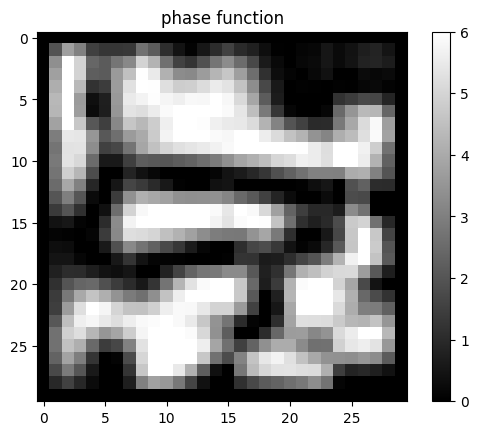

In [10]:
import numpy as np

# 创建一个 50x50 的矩阵，使得每一行的数就是该行的序号
matrix = np.tile(np.arange(50).reshape(50, 1), (1, 50))

y_map=np.tile(np.arange(30),(50,1))
print(matrix)
print(y_map)

[[ 0  0  0 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 2  2  2 ...  2  2  2]
 ...
 [47 47 47 ... 47 47 47]
 [48 48 48 ... 48 48 48]
 [49 49 49 ... 49 49 49]]
[[ 0  1  2 ... 27 28 29]
 [ 0  1  2 ... 27 28 29]
 [ 0  1  2 ... 27 28 29]
 ...
 [ 0  1  2 ... 27 28 29]
 [ 0  1  2 ... 27 28 29]
 [ 0  1  2 ... 27 28 29]]
